In [376]:
import rawpy
import requests
import os
from matplotlib import pyplot as plt
import cv2
import numpy as np
from tqdm import tqdm
from scipy.signal import convolve2d
from PIL import Image

# Read CFA data

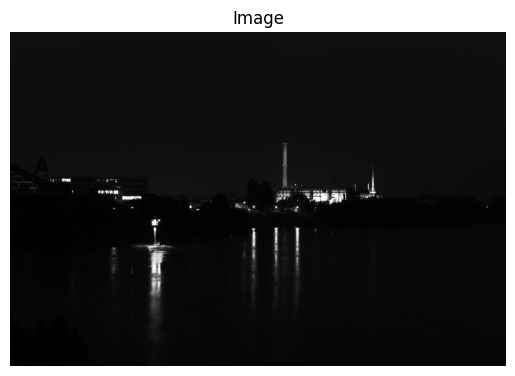

In [377]:
def pull_image():
    """
    In order to extract the CFA data from Digital Negative (.DNG) files we use dcraw.c
    http://www.dechifro.org/dcraw/dcraw.c
    """
    # raw_data = Image.open('L1004432.tiff')
    raw_data = Image.open('sample.tiff')
    raw = np.array(raw_data).astype(np.double)
    return raw

im = pull_image()
plt.axis('off')
plt.title("Image")
plt.imshow(im, cmap="gray")

# Normalization

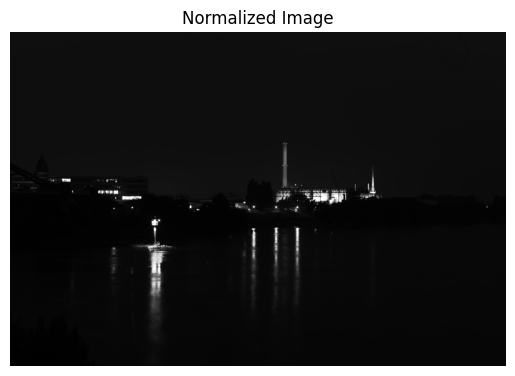

In [378]:
"""
Scaling with darkness <black>, saturation <white>,
and multipliers <r_scale> <g_scale> <b_scale> <g_scale>

Scaling with darkness 44, saturation 16383, and
multipliers 2.264263 1.000000 1.195190 1.000000
"""

black = 0
white = 16383
R_scale = 2.217041
G_scale = 1.000000
B_scale = 1.192484

def normalize_uint8(img, maxval, minval):
    """
    img: uint16 2d raw image
    out: uint8 2d normalized 0-255 image
    https://en.wikipedia.org/wiki/Normalization_(image_processing)
    """
    return (np.rint((img - img.min()) * ((maxval - minval) / (img.max() - img.min())) + minval)).astype(dtype='uint8')

def min_max_normalization(img, maxval, minval):
    """
    https://en.wikipedia.org/wiki/Feature_scaling#Rescaling_(min-max_normalization)
    """
    return (img - minval) / (maxval-minval)

im_norm = min_max_normalization(im, white, black)

plt.axis('off')
plt.title("Normalized Image")
plt.imshow(im_norm, cmap="gray")


# White balancing

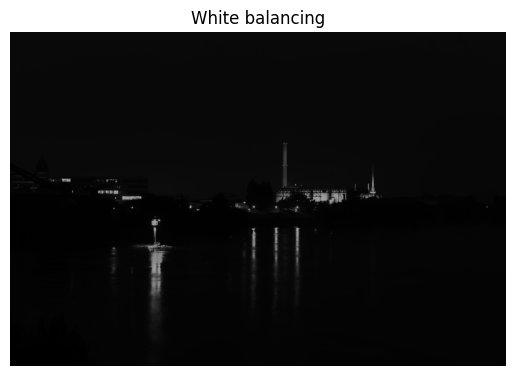

In [379]:
def whitebalance(im, rgbScales=[1,1,1]):

    # generate the white balancing matrix
    
    scalematrix = rgbScales[1] * np.ones(im.shape)
    
    # rggb
    scalematrix[0::2, 0::2] = rgbScales[0]
    scalematrix[1::2, 1::2] = rgbScales[2]
    
    return np.multiply(im, scalematrix)
    
im_wb = whitebalance(im_norm, rgbScales = [R_scale, G_scale, B_scale])

plt.axis('off')
plt.title("White balancing")
plt.imshow(im_wb, cmap="gray")

# Color filtering

In [380]:
def bayer(im):
    r = np.zeros(im.shape[:2])
    g = np.zeros(im.shape[:2])
    b = np.zeros(im.shape[:2])
    r[0::2, 0::2] += im[0::2, 0::2]
    g[0::2, 1::2] += im[0::2, 1::2]
    g[1::2, 0::2] += im[1::2, 0::2]
    b[1::2, 1::2] += im[1::2, 1::2]
    return r, g, b

# Demosaicing

### Single-channel interpolation

Single-channel interpolation methods treat each channel separately without utilizing any inter-channel correlation. Standard image interpolation techniques, such as bilinear/bicubic interpolation.

In [381]:
def bilinear(im):
    r, g, b = bayer(im)

    # green interpolation

    k_g = 1/4 * np.array([[0,1,0],[1,0,1],[0,1,0]])
    convg =convolve2d(g, k_g, 'same')
    g = g + convg

    # red interpolation

    k_r_1 = 1/4 * np.array([[1,0,1],[0,0,0],[1,0,1]])
    convr1 =convolve2d(r, k_r_1, 'same')
    convr2 =convolve2d(r+convr1, k_g, 'same')
    r = r + convr1 + convr2

    # blue interpolation

    k_b_1 = 1/4 * np.array([[1,0,1],[0,0,0],[1,0,1]])
    convb1 =convolve2d(b, k_b_1, 'same')
    convb2 =convolve2d(b+convb1, k_g, 'same')
    b = b + convb1 + convb2
    
    return r, g, b

r, g, b = bilinear(im_wb)

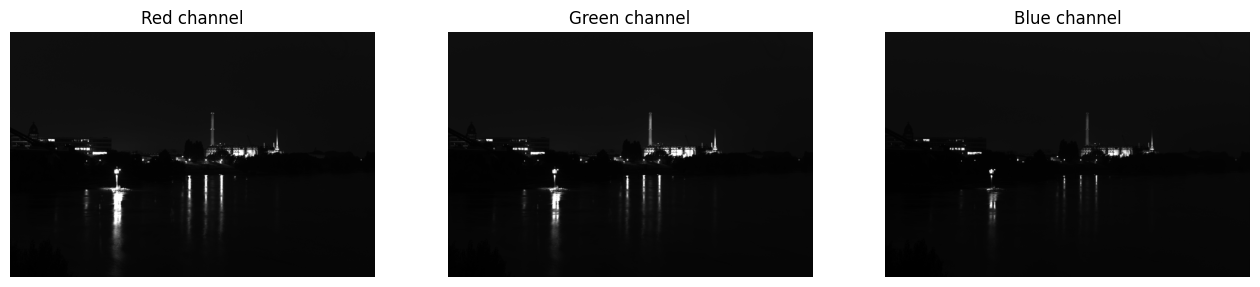

In [382]:
fig = plt.figure(figsize=(16, 16))

fig.add_subplot(1, 3, 1)
plt.axis('off')
plt.title("Red channel")
plt.imshow(r, cmap="gray")

fig.add_subplot(1, 3, 2)
plt.axis('off')
plt.title("Green channel")
plt.imshow(g, cmap="gray")

fig.add_subplot(1, 3, 3)
plt.axis('off')
plt.title("Blue channel")
plt.imshow(b, cmap="gray")

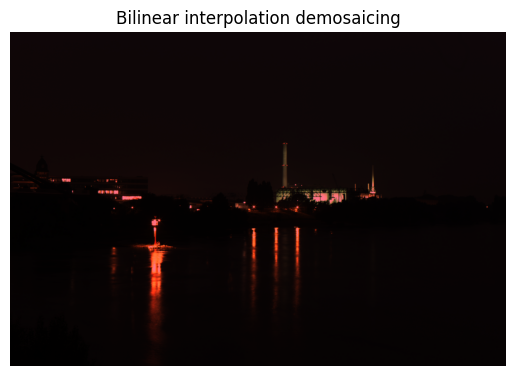

In [386]:
image = np.stack((r,g,b), axis=2)

plt.axis('off')
plt.title("Bilinear interpolation demosaicing")
plt.imshow(image)

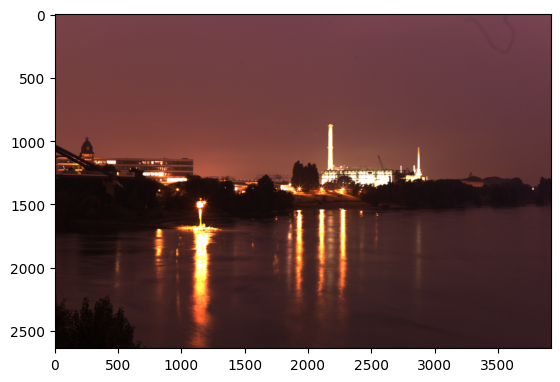

In [387]:
def apply_cmatrix(img, cmatrix):
    # Applies color transformation CMATRIX to RGB input IM. 
    # Finds the appropriate weighting of the old color planes to form the new color planes, 
    # equivalent to but much more efficient than applying a matrix transformation to each pixel.
    if (img.shape[2] != 3):
        raise ValueError('Apply cmatrix to RGB image only.')

    r = cmatrix[0,0] * img[:,:,0] + cmatrix[0,1] * img[:,:,1] + cmatrix[0,2] * img[:,:,2]
    g = cmatrix[1,0] * img[:,:,0] + cmatrix[1,1] * img[:,:,1] + cmatrix[1,2] * img[:,:,2]
    b = cmatrix[2,0] * img[:,:,0] + cmatrix[2,1] * img[:,:,1] + cmatrix[2,2] * img[:,:,2]
    corrected = np.stack((r,g,b), axis=2)
    return corrected

rgb2xyz = np.array([[0.4124564, 0.3575761, 0.1804375],
           [0.2126729, 0.7151522, 0.0721750],
           [0.0193339, 0.1191920, 0.9503041]])

xyz2cam = np.array([[0.6653, -0.1486, -0.0611],
           [-0.4221, 1.3303, 0.0929],
           [-0.0881, 0.2416, 0.7226]])
rgb2cam = xyz2cam * rgb2xyz # Assuming previously defined matrices
denom = np.tile(np.reshape(np.sum(rgb2cam,axis=1),(3,-1)), (1,3))
rgb2cam = np.divide(rgb2cam, denom) # Normalize rows to 1
cam2rgb = np.linalg.inv(rgb2cam)
lin_srgb = apply_cmatrix(image, cam2rgb)
lin_srgb[lin_srgb > 1.0] = 1.0 # Always keep image clipped b/w 0-1
lin_srgb[lin_srgb < 0.0] = 0.0
plt.imshow(img_n)

## Gradient Correction Interpolation

If at a given missing pixel location for G channel Gx, we have a red pixel Rx we have to take that into account too.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


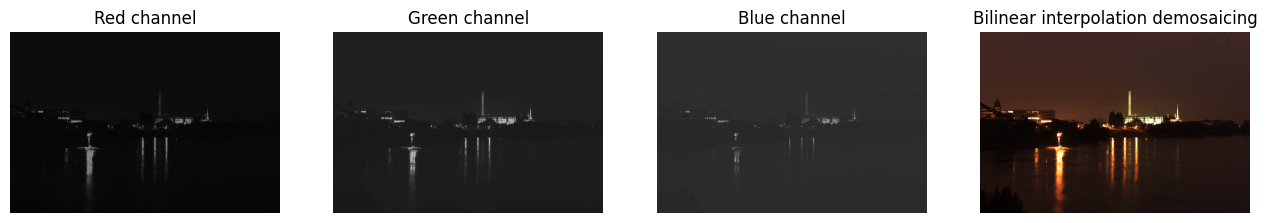

In [391]:
def gradient_correction(im):
    
    r, g, b = bayer(im)
    
    # each channel has the same dimension
    rows = g.shape[0]
    cols = g.shape[1]
    
    # green interpolation
    
    GatRB = np.array([
        [   0,   0,  -1,   0,   0],
        [   0,   0,   2,   0,   0],
        [  -1,   2,   4,   2,  -1],
        [   0,   0,   2,   0,   0],
        [   0,   0,  -1,   0,   0]
    ])

    out_g = np.zeros(g.shape)
    out_g[:] = g
    for i in range(rows - 5):
        for j in range(cols - 5):
            if g[i+2, j+2] == 0:
                gx = g[i:i+5, j:j+5]
                if r[i+2, j+2] != 0:
                    # G at R location
                    rx = r[i:i+5, j:j+5]
                    out_g[i+2, j+2] = np.average(gx * GatRB + rx * GatRB)
                elif b[i+2, j+2] != 0:
                    # G at B location
                    bx = b[i:i+5, j:j+5]
                    out_g[i+2, j+2] = np.average(gx * GatRB + bx * GatRB)
        
    # red interpolation
    
    RatGrow = np.array([
        [   0,   0, 1/2,   0,   0],
        [   0,  -1,   0,  -1,   0],
        [  -1,   4,   5,   4,  -1],
        [   0,  -1,   0,  -1,   0],
        [   0,   0, 1/2,   0,   0]
    ])
    
    RatGcol = np.array([
        [   0,   0,  -1,   0,   0],
        [   0,  -1,   4,  -1,   0],
        [ 1/2,   0,   5,   0, 1/2],
        [   0,  -1,   4,  -1,   0],
        [   0,   0,  -1,   0,   0]
    ])
    
    RatB = np.array([
        [   0,   0,-3/2,   0,   0],
        [   0,   2,   0,   2,   0],
        [-3/2,   0,   6,   0,-3/2],
        [   0,   2,   0,   2,   0],
        [   0,   0,-3/2,   0,   0]
    ])
    
    out_r = np.zeros(g.shape)
    out_r[:] = r
    for i in range(rows - 5):
        for j in range(cols - 5):
            if r[i+2, j+2] == 0:
                rx = r[i:i+5, j:j+5]
                if g[i+2, j+2] != 0 and (r[i+2, j+1] != 0 and r[i+2, j+3] != 0):
                    # R at G, R row
                    gx = g[i:i+5, j:j+5]
                    out_r[i+2, j+2] = np.average(gx * RatGrow + rx * RatGrow)
                elif g[i+2, j+2] != 0 and (r[i+1, j+2] != 0 and r[i+3, j+2] != 0):
                    # R at G, R col
                    gx = g[i:i+5, j:j+5]
                    out_r[i+2, j+2] = np.average(gx * RatGcol + rx * RatGcol)
                elif b[i+2, j+2] != 0:
                    # R at B
                    bx = b[i:i+5, j:j+5]
                    out_r[i+2, j+2] = np.average(bx * RatB + rx * RatB)
    
    BatGrow = RatGrow
    BatGcol = RatGcol
    BatR = RatB
    
    out_b = np.zeros(g.shape)
    out_b[:] = b
    for i in range(rows - 5):
        for j in range(cols - 5):
            if b[i+2, j+2] == 0:
                bx = b[i:i+5, j:j+5]
                if g[i+2, j+2] != 0 and (b[i+2, j+1] != 0 and b[i+2, j+3] != 0):
                    # R at G, R row
                    gx = g[i:i+5, j:j+5]
                    out_b[i+2, j+2] = np.average(gx * BatGrow + bx * BatGrow)
                elif g[i+2, j+2] != 0 and (b[i+1, j+2] != 0 and b[i+3, j+2] != 0):
                    # R at G, R col
                    gx = g[i:i+5, j:j+5]
                    out_b[i+2, j+2] = np.average(gx * BatGcol + bx * BatGcol)
                elif r[i+2, j+2] != 0:
                    # B at R
                    rx = r[i:i+5, j:j+5]
                    out_b[i+2, j+2] = np.average(bx * BatR + rx * BatR)
    
    return out_r, out_g, out_b

r_grad, g_grad, b_grad = gradient_correction(im_wb)

image = np.stack((r_grad,g_grad,b_grad), axis=2)

fig = plt.figure(figsize=(16, 16))

fig.add_subplot(1, 3, 1)
plt.axis('off')
plt.title("Red channel")
plt.imshow(r_grad, cmap="gray")

fig.add_subplot(1, 3, 2)
plt.axis('off')
plt.title("Green channel")
plt.imshow(g_grad, cmap="gray")

fig.add_subplot(1, 3, 3)
plt.axis('off')
plt.title("Blue channel")
plt.imshow(b_grad, cmap="gray")

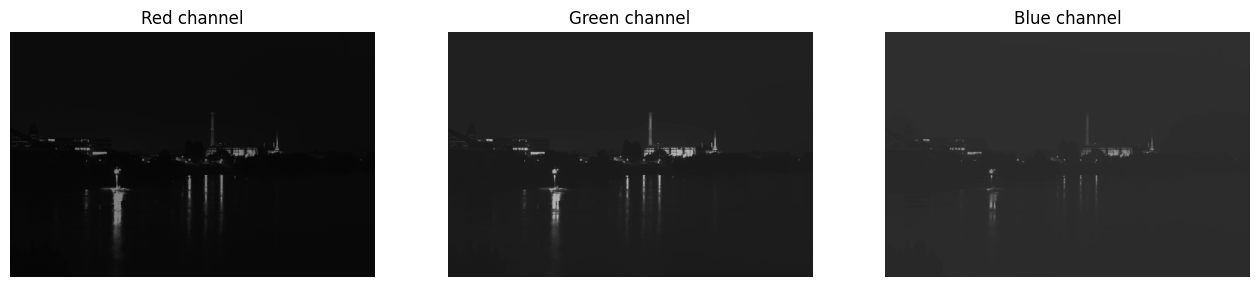

In [407]:
fig = plt.figure(figsize=(16, 16))

fig.add_subplot(1, 3, 1)
plt.axis('off')
plt.title("Red channel")
plt.imshow(r_grad, cmap="gray")

fig.add_subplot(1, 3, 2)
plt.axis('off')
plt.title("Green channel")
plt.imshow(g_grad, cmap="gray")

fig.add_subplot(1, 3, 3)
plt.axis('off')
plt.title("Blue channel")
plt.imshow(b_grad, cmap="gray")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


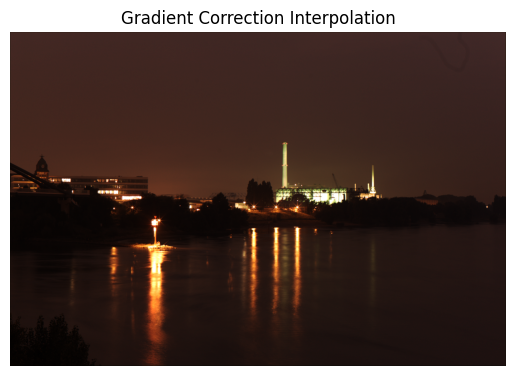

In [406]:
plt.axis('off')
plt.title("Gradient Correction Interpolation")
plt.imshow(image)